In [1]:
import numpy as np
#from keras import *
#from keras.models import Sequential
#from keras.layers import Dense, Conv2D
#from keras.layers.noise import GaussianDropout
#from keras.layers import Flatten, AveragePooling2D, UpSampling2D, Conv2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
k_B = 1.38e-23 # Boltzmann cte. in J / K
T = 300 # temperature in Kelvin
dt = 1e-4
max_time = 1
x0 = 0.0
gamma =  1.29926e-9

n_t = 1000 #training sample size
b_size = 100 #batch size do trainamento
epocas = 5 #epocas de treinamento

trace_size = int((max_time/dt)+1)  

spread_min = 20
spread_max = 40

In [3]:
def linear_simulation(t_max, dt, initial_position, k_spring, gamma):
    """
    Simulate the brownian movement of a overdamped system under linear force 
    through Euler-Maruyama method 

    Parameters
    ----------
    t_max            : final simulation time, such that t \in (0, t_max)
    dt               : time increment
    initial_position : initial condition
    k_spring         : spring constant
    g                : damping constant

    Returns
    -------
    save_times : array with time stamps
    positions : array with simulated positions

    """
    

    N_time = int(t_max/dt)    
    # Number of time stamps
    t = np.linspace(0, t_max, N_time)                                                   # Array with time stamps
    
    positions = np.zeros(N_time)                                               # Array to store calculated positions
    positions[0] = initial_position                                             # Define initial condition
    
    w = np.sqrt(2.0 * k_B * T * dt / gamma) * np.random.normal(size=N_time)       # Wiener increment
    
    for i in range(N_time-1):                                                    # Loop through each time stamp and calculate current position
        positions[i+1] = positions[i] - (k_spring/gamma) * positions[i] * dt + w[i] # Euler-Maruyama method 
        
    return positions

In [4]:
def non_linear_simulation(t_max, dt, initial_position, k_spring, k_a, gamma):
    """
    Simulate the brownian movement of a overdamped system under the influence of non-linearity
    through Euler-Maruyama method 

    Parameters
    ----------
    t_max            : final simulation time, such that t \in (0, t_max)
    dt               : time increment
    initial_position : initial condition
    k_spring         : spring constant
    g                : damping constant
    k_a              : non-linear constant

    Returns
    -------
    save_times : array with time stamps
    positions : array with simulated positions

    """
    
    N_time = int(t_max/dt)                                                      # Number of time stamps
    t = np.linspace(0, t_max, N_time)                                                   # Array with time stamps
    
    positions = np.zeros(N_time)                                               # Array to store calculated positions
    positions[0] = initial_position                                             # Define initial condition
    
    w = np.sqrt(2.0 * k_B * T * dt / gamma) * np.random.normal(size=N_time)       # Wiener increment
    
    for i in range(N_time-1):                                                  # Loop through each time stamp and calculate current position
        positions[i+1] = positions[i] - (k_spring/gamma)*positions[i]*dt - (k_a/gamma)*((positions[i])**3)*dt + w[i] # Euler-Maruyama method 
        
    return positions

In [5]:
linear_simulation(max_time,dt,x0,20*gamma,gamma)

array([ 0.00000000e+00, -5.84416293e-08, -5.59067644e-08, ...,
       -6.56315169e-07, -6.70643618e-07, -7.27243967e-07])

In [5]:
def create_samples(num_samples):
    
    k_array = np.linspace(spread_min, spread_max, num=int(num_samples/2))
    k_array = k_array * gamma
    linear = np.array([np.append(linear_simulation(max_time,dt,x0,k,gamma), 0.0) for k in k_array])

    non_linear = np.array([np.append(non_linear_simulation(max_time,dt,x0,k,k*0.5*1e14,gamma), 0.0) for k in k_array])
    
    max_value =  max(np.max(linear), np.max(non_linear))
    linear = linear/max_value
    non_linear = non_linear/max_value
    linear[:,10000]=1.0
    
    linear = np.float32(linear)
    non_linear = np.float32(non_linear)
    
    
    samples = np.concatenate((linear,non_linear), axis=0)
    np.random.shuffle(samples)
    return samples

In [6]:
samples = create_samples(100000)

In [11]:
train = samples[:750]
val = samples[750:875]
test = samples[875:]

np.save("train.npy", train, allow_pickle=False)
np.save("val.npy", val, allow_pickle=False)
np.save("test.npy", test, allow_pickle=False)

In [248]:
np.shape(train)

(750, 10001)

In [153]:
teste[4]

array([ 0.00000000e+00,  1.42783380e-08,  9.83866907e-09, ...,
       -2.63558633e-07, -2.50283556e-07,  0.00000000e+00])

In [221]:
np.shape(l)

(1, 10001)

In [224]:
linear_simulation(max_time,dt,x0,20,gamma)

<ipython-input-223-0faf72754248>:32: RuntimeWarning: overflow encountered in double_scalars
  positions[i+1] = positions[i] - (k_spring/gamma) * positions[i] * dt + w[i] # Euler-Maruyama method
<ipython-input-223-0faf72754248>:32: RuntimeWarning: invalid value encountered in double_scalars
  positions[i+1] = positions[i] - (k_spring/gamma) * positions[i] * dt + w[i] # Euler-Maruyama method


IndexError: index 10001 is out of bounds for axis 0 with size 10001

In [6]:
training_inputs = np.zeros([n_t,int((max_time/dt)+1)]) #matriz que guarda os exemplos de treinamento
training_results = np.zeros([n_t,2]) #matriz que guarda o resultado que queremos para cada exemplo. Caso o exemplo seja linear a linha da matriz vale 1 0, caso seja não linear a linha vale 0 1

In [9]:
spread_min = 20
spread_max = 40

k = np.random.uniform(spread_min*gamma,spread_max*gamma)
linear_simulation(max_time,dt,x0,k,gamma)

array([0.00000000e+00, 2.76675370e-08, 6.00784671e-08, ...,
       2.33166284e-07, 2.01092619e-07, 2.30797685e-07])

In [21]:
#criando a rede neural
net = Sequential()
net.add(Dense(int(trace_size/2), input_shape=(trace_size,), activation='relu'))
net.add(Dense(int(trace_size/4), activation='relu'))
net.add(Dense(2, activation='softmax'))
net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.1), metrics=['categorical_accuracy'])

In [22]:
val_per = np.zeros(30)

for on in range(30):
    print(on)
    spread_min = 20
    spread_max = 40
    
    for i in range(n_t):
        
        sorteio_tipo  = np.random.randint(0,2)      #se 0 vai gerar linear, se 1 vai gerar não-linear
        if sorteio_tipo == 0:
            k = np.random.uniform(spread_min*gamma,spread_max*gamma)
            training_inputs[i,:] = linear_simulation(max_time,dt,x0,k,gamma)
            training_inputs[i,:] = training_inputs[i,:]/np.max(training_inputs[i,:]) #essa linha normaliza o traço, mas não sei se isso é necessário
            training_results[i][0] = 1
            training_results[i][1] = 0 
        else:
            k = np.random.uniform(spread_min*gamma,spread_max*gamma)
            ka = np.random.uniform(0,k*0.5*1e14)
            training_inputs[i,:] = non_linear_simulation(max_time,dt,x0,k,ka,gamma)
            training_inputs[i,:] = training_inputs[i,:]/np.max(training_inputs[i,:]) #essa linha normaliza o traço, mas não sei se isso é necessário
            training_results[i][0] = 0
            training_results[i][1] = 1 
            
    net.fit(training_inputs,training_results,batch_size=b_size, epochs=epocas,validation_split=0.1)
    
    for i in range(n_t):
        
        sorteio_tipo  = np.random.randint(0,2)      #se 0 vai gerar linear, se 1 vai gerar não-linear
        if sorteio_tipo == 0:
            k = np.random.uniform(spread_min*gamma,spread_max*gamma)
            training_inputs[i,:] = linear_simulation(max_time,dt,x0,k,gamma)
            training_inputs[i,:] = training_inputs[i,:]/np.max(training_inputs[i,:]) #essa linha normaliza o traço, mas não sei se isso é necessário
            training_results[i][0] = 1
            training_results[i][1] = 0 
        else:
            k = np.random.uniform(spread_min*gamma,spread_max*gamma)
            ka = np.random.uniform(0,k*0.5*1e14)
            training_inputs[i,:] = non_linear_simulation(max_time,dt,x0,k,ka,gamma)
            training_inputs[i,:] = training_inputs[i,:]/np.max(training_inputs[i,:]) #essa linha normaliza o traço, mas não sei se isso é necessário
            training_results[i][0] = 0
            training_results[i][1] = 1 
            
    prediction = net.predict(training_inputs)
    for i in range(len(prediction)):
        if prediction[i,0] > 0.5:
            prediction[i,0] = 1
            prediction[i,1] = 0
        else:
            prediction[i,0] = 0
            prediction[i,1] = 1
            
    val = (prediction == training_results)
    for i in range(len(val)):
        if val[i,0] == 1:
            val_per[on] += 1
            
    val_per[on] = val_per[on]/len(val)

0
Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 9s 10ms/step - loss: 1.2672 - categorical_accuracy: 0.5500 - val_loss: 0.5636 - val_categorical_accuracy: 0.7000
Epoch 2/5
900/900 [==============================] - 7s 8ms/step - loss: 0.4395 - categorical_accuracy: 0.8689 - val_loss: 0.4956 - val_categorical_accuracy: 0.8000
Epoch 3/5
900/900 [==============================] - 7s 8ms/step - loss: 0.2758 - categorical_accuracy: 0.9678 - val_loss: 0.4386 - val_categorical_accuracy: 0.8300
Epoch 4/5
900/900 [==============================] - 7s 7ms/step - loss: 0.1744 - categorical_accuracy: 0.9867 - val_loss: 0.4795 - val_categorical_accuracy: 0.7800
Epoch 5/5
900/900 [==============================] - 7s 8ms/step - loss: 0.1093 - categorical_accuracy: 0.9967 - val_loss: 0.4390 - val_categorical_accuracy: 0.7900
1
Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 7s 8ms/step - loss: 0.942

Epoch 4/5
900/900 [==============================] - 8s 9ms/step - loss: 0.0205 - categorical_accuracy: 1.0000 - val_loss: 0.5176 - val_categorical_accuracy: 0.8400
Epoch 5/5
900/900 [==============================] - 9s 10ms/step - loss: 0.0150 - categorical_accuracy: 1.0000 - val_loss: 0.5350 - val_categorical_accuracy: 0.8400
19
Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 7s 8ms/step - loss: 0.4396 - categorical_accuracy: 0.8378 - val_loss: 0.3409 - val_categorical_accuracy: 0.8500
Epoch 2/5
900/900 [==============================] - 7s 8ms/step - loss: 0.1040 - categorical_accuracy: 0.9633 - val_loss: 0.3729 - val_categorical_accuracy: 0.8300
Epoch 3/5
900/900 [==============================] - 7s 8ms/step - loss: 0.0343 - categorical_accuracy: 0.9978 - val_loss: 0.3538 - val_categorical_accuracy: 0.8400
Epoch 4/5
900/900 [==============================] - 8s 8ms/step - loss: 0.0192 - categorical_accuracy: 1.0000 - val_loss: 0.

28
Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 7s 7ms/step - loss: 0.5013 - categorical_accuracy: 0.8267 - val_loss: 0.2711 - val_categorical_accuracy: 0.8900
Epoch 2/5
900/900 [==============================] - 7s 7ms/step - loss: 0.1060 - categorical_accuracy: 0.9678 - val_loss: 0.2569 - val_categorical_accuracy: 0.8700
Epoch 3/5
900/900 [==============================] - 7s 8ms/step - loss: 0.0409 - categorical_accuracy: 0.9967 - val_loss: 0.2433 - val_categorical_accuracy: 0.8800
Epoch 4/5
900/900 [==============================] - 7s 7ms/step - loss: 0.0228 - categorical_accuracy: 1.0000 - val_loss: 0.2441 - val_categorical_accuracy: 0.8800
Epoch 5/5
900/900 [==============================] - 7s 7ms/step - loss: 0.0164 - categorical_accuracy: 1.0000 - val_loss: 0.2542 - val_categorical_accuracy: 0.8800
29
Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 7s 8ms/step - loss: 0.33

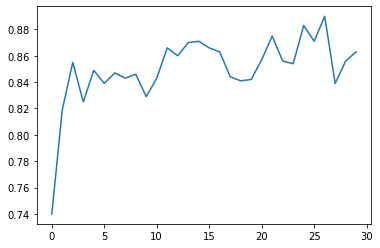

In [23]:
plt.plot(val_per)

In [24]:
30*900

27000

In [25]:
30*900*5

135000